## Risky Business

### Prompt

*"One of the most important aspects of financial decisioning is the ability to evaluate and manage risk. For analysts especially, this is a critical part of the job description and requires a strong understanding of finance and statistics. Furthermore, the ability to script in Python is a helpful skill to run bulk analysis efficiently. In this exercise, you will assume the role of an analyst tasked with predicting credit risk using free data from peer-to-peer lending services."*

### Approach
The first step is finding the data - apparently this prompt is not uncommon on Kaggle:
- [LoanData_Bondora.csv](https://www.kaggle.com/datasets/sid321axn/bondora-peer-to-peer-lending-loan-data)
- [LendingClub_2007_to_2018Q4](https://www.kaggle.com/datasets/wordsforthewise/lending-club?select=accepted_2007_to_2018Q4.csv.gz)
- [LCDataDictionary.xlsx](https://www.kaggle.com/datasets/ethon0426/lending-club-20072020q1)
- [Master_Loan_Summary.csv](https://www.kaggle.com/datasets/skihikingkevin/online-p2p-lending)

The plan is to walkthrough [this notebook](https://www.kaggle.com/code/leventoz/default-loans-predictor-acc-99-99/notebook) on Kaggle with the first dataset (Bondora) then see if we can repeat / combine results from the others.

### Dataset 1: Bondora

#### Setup

In [1]:
data_dir = './data'
import os
assert os.path.exists(data_dir)

In [2]:
bondora_path = os.path.join(data_dir, 'LoanData_Bondora.csv')
assert os.path.exists(bondora_path)

In [3]:
import pandas
data = pandas.read_csv(bondora_path, low_memory=False)

#### Dropping Null Columns

In [4]:
data.columns

Index(['ReportAsOfEOD', 'LoanId', 'LoanNumber', 'ListedOnUTC',
       'BiddingStartedOn', 'BidsPortfolioManager', 'BidsApi', 'BidsManual',
       'UserName', 'NewCreditCustomer',
       ...
       'PreviousEarlyRepaymentsCountBeforeLoan', 'GracePeriodStart',
       'GracePeriodEnd', 'NextPaymentDate', 'NextPaymentNr',
       'NrOfScheduledPayments', 'ReScheduledOn', 'PrincipalDebtServicingCost',
       'InterestAndPenaltyDebtServicingCost', 'ActiveLateLastPaymentCategory'],
      dtype='object', length=112)

In [5]:
data.isnull().sum()

ReportAsOfEOD                               0
LoanId                                      0
LoanNumber                                  0
ListedOnUTC                                 0
BiddingStartedOn                            0
                                        ...  
NrOfScheduledPayments                   66944
ReScheduledOn                          116191
PrincipalDebtServicingCost             103085
InterestAndPenaltyDebtServicingCost    103085
ActiveLateLastPaymentCategory           96967
Length: 112, dtype: int64

The last output wasn't useful, let's filter for the 0 results...

In [6]:
data.isnull().sum() > 0

ReportAsOfEOD                          False
LoanId                                 False
LoanNumber                             False
ListedOnUTC                            False
BiddingStartedOn                       False
                                       ...  
NrOfScheduledPayments                   True
ReScheduledOn                           True
PrincipalDebtServicingCost              True
InterestAndPenaltyDebtServicingCost     True
ActiveLateLastPaymentCategory           True
Length: 112, dtype: bool

...but correctly this time.

In [7]:
nonzero_null = []
for scale, col in enumerate(data.columns):
    if pandas.Series(data[col]).isnull().sum() > 0:
        nonzero_null.append(col)

nonzero_null

['ContractEndDate',
 'VerificationType',
 'DateOfBirth',
 'Gender',
 'MonthlyPayment',
 'County',
 'City',
 'Education',
 'MaritalStatus',
 'NrOfDependants',
 'EmploymentStatus',
 'EmploymentDurationCurrentEmployer',
 'EmploymentPosition',
 'WorkExperience',
 'OccupationArea',
 'HomeOwnershipType',
 'DebtToIncome',
 'FreeCash',
 'PlannedPrincipalTillDate',
 'PlannedInterestTillDate',
 'LastPaymentOn',
 'CurrentDebtDaysPrimary',
 'DebtOccuredOn',
 'CurrentDebtDaysSecondary',
 'DebtOccuredOnForSecondary',
 'ExpectedLoss',
 'LossGivenDefault',
 'ExpectedReturn',
 'ProbabilityOfDefault',
 'DefaultDate',
 'PrincipalOverdueBySchedule',
 'PlannedPrincipalPostDefault',
 'PlannedInterestPostDefault',
 'EAD1',
 'EAD2',
 'PrincipalRecovery',
 'InterestRecovery',
 'RecoveryStage',
 'StageActiveSince',
 'ModelVersion',
 'Rating',
 'EL_V0',
 'Rating_V0',
 'EL_V1',
 'Rating_V1',
 'Rating_V2',
 'ActiveLateCategory',
 'WorseLateCategory',
 'CreditScoreEsMicroL',
 'CreditScoreEsEquifaxRisk',
 'CreditSco

In [8]:
len(data.columns) - len(nonzero_null)

43

That's less than half of the 112 starting columns. Is there a sweet spot for null tolerance where more of the data can be kept?

In [9]:
num_cols_at_tolerance = {}
for tolerance_pct in range(0, 100, 10):
    null_threshold = int(len(data.index) * (tolerance_pct / 100))
    within_tolerance = 0
    for col in data.columns:
        if pandas.Series(data[col]).isnull().sum() <= null_threshold:
            within_tolerance += 1
    num_cols_at_tolerance[tolerance_pct] = within_tolerance

for tolerance_pct in num_cols_at_tolerance:
    print(f'Null Tolerance: {tolerance_pct:2d}% -> Columns Left: {num_cols_at_tolerance[tolerance_pct]:3d} / 112')

Null Tolerance:  0% -> Columns Left:  43 / 112
Null Tolerance: 10% -> Columns Left:  67 / 112
Null Tolerance: 20% -> Columns Left:  68 / 112
Null Tolerance: 30% -> Columns Left:  69 / 112
Null Tolerance: 40% -> Columns Left:  74 / 112
Null Tolerance: 50% -> Columns Left:  76 / 112
Null Tolerance: 60% -> Columns Left:  86 / 112
Null Tolerance: 70% -> Columns Left:  97 / 112
Null Tolerance: 80% -> Columns Left: 101 / 112
Null Tolerance: 90% -> Columns Left: 103 / 112


~~Based on the above I may as well cut any column with nulls - even at 0 tolerance there's still 43 columns to work with.~~

Ended up going to ~~20%~~ 50% null tolerance to preserve more object columns.

In [10]:
keep_features = []
tolerance = 0.5 # 0.2
for col in data.columns:
    if pandas.Series(data[col]).isnull().sum() <= int(tolerance * len(data.index)):
        keep_features.append(col)

keep_features

['ReportAsOfEOD',
 'LoanId',
 'LoanNumber',
 'ListedOnUTC',
 'BiddingStartedOn',
 'BidsPortfolioManager',
 'BidsApi',
 'BidsManual',
 'UserName',
 'NewCreditCustomer',
 'LoanApplicationStartedDate',
 'LoanDate',
 'ContractEndDate',
 'FirstPaymentDate',
 'MaturityDate_Original',
 'MaturityDate_Last',
 'ApplicationSignedHour',
 'ApplicationSignedWeekday',
 'VerificationType',
 'LanguageCode',
 'Age',
 'Gender',
 'Country',
 'AppliedAmount',
 'Amount',
 'Interest',
 'LoanDuration',
 'MonthlyPayment',
 'UseOfLoan',
 'Education',
 'MaritalStatus',
 'EmploymentStatus',
 'EmploymentDurationCurrentEmployer',
 'OccupationArea',
 'HomeOwnershipType',
 'IncomeFromPrincipalEmployer',
 'IncomeFromPension',
 'IncomeFromFamilyAllowance',
 'IncomeFromSocialWelfare',
 'IncomeFromLeavePay',
 'IncomeFromChildSupport',
 'IncomeOther',
 'IncomeTotal',
 'ExistingLiabilities',
 'LiabilitiesTotal',
 'RefinanceLiabilities',
 'DebtToIncome',
 'FreeCash',
 'MonthlyPaymentDay',
 'ActiveScheduleFirstPaymentReached

In [11]:
# drop_features = list(set(raw_data.columns.values.tolist()) - set(keep_features)) # sets also work here but I prefer list comp
drop_features = [col for col in data.columns.values.tolist() if col not in keep_features]
scrubbed_data = data.drop(drop_features, axis=1)
scrubbed_data.columns

Index(['ReportAsOfEOD', 'LoanId', 'LoanNumber', 'ListedOnUTC',
       'BiddingStartedOn', 'BidsPortfolioManager', 'BidsApi', 'BidsManual',
       'UserName', 'NewCreditCustomer', 'LoanApplicationStartedDate',
       'LoanDate', 'ContractEndDate', 'FirstPaymentDate',
       'MaturityDate_Original', 'MaturityDate_Last', 'ApplicationSignedHour',
       'ApplicationSignedWeekday', 'VerificationType', 'LanguageCode', 'Age',
       'Gender', 'Country', 'AppliedAmount', 'Amount', 'Interest',
       'LoanDuration', 'MonthlyPayment', 'UseOfLoan', 'Education',
       'MaritalStatus', 'EmploymentStatus',
       'EmploymentDurationCurrentEmployer', 'OccupationArea',
       'HomeOwnershipType', 'IncomeFromPrincipalEmployer', 'IncomeFromPension',
       'IncomeFromFamilyAllowance', 'IncomeFromSocialWelfare',
       'IncomeFromLeavePay', 'IncomeFromChildSupport', 'IncomeOther',
       'IncomeTotal', 'ExistingLiabilities', 'LiabilitiesTotal',
       'RefinanceLiabilities', 'DebtToIncome', 'FreeCash', 

In [12]:
len(scrubbed_data.columns) == len(keep_features) # sanity check

True

In [13]:
print(scrubbed_data.describe().transpose())

                                           count          mean            std  \
LoanNumber                              179235.0  1.239306e+06  661026.577241   
BidsPortfolioManager                    179235.0  7.979625e+02    1235.509764   
BidsApi                                 179235.0  2.743234e+01     147.568318   
BidsManual                              179235.0  4.995448e+02     714.723996   
ApplicationSignedHour                   179235.0  1.332526e+01       4.995317   
ApplicationSignedWeekday                179235.0  3.917907e+00       1.752335   
VerificationType                        179185.0  3.043402e+00       1.352504   
LanguageCode                            179235.0  2.675153e+00       1.874840   
Age                                     179235.0  4.038914e+01      12.359547   
Gender                                  179190.0  4.668006e-01       0.620359   
AppliedAmount                           179235.0  2.699128e+03    2342.758228   
Amount                      

At this point any column with ~~0% < 20%~~ < 50% null values has been removed, but there are still non-numeric columns that have to be converted before processing.

#### Encoding Categorical Data

In [14]:
scrubbed_data.dtypes

ReportAsOfEOD                              object
LoanId                                     object
LoanNumber                                  int64
ListedOnUTC                                object
BiddingStartedOn                           object
                                           ...   
AmountOfPreviousLoansBeforeLoan           float64
PreviousRepaymentsBeforeLoan              float64
PreviousEarlyRepaymentsCountBeforeLoan    float64
NextPaymentNr                             float64
NrOfScheduledPayments                     float64
Length: 76, dtype: object

In [15]:
set(scrubbed_data.dtypes.values.tolist())

{dtype('bool'), dtype('int64'), dtype('float64'), dtype('O')}

Compare that to the types in the unfiltered column dtypes, in case some were dropped:

In [16]:
set(data.dtypes.values.tolist())

{dtype('bool'), dtype('int64'), dtype('float64'), dtype('O')}

Good. 'O' is the 'object' type, which could be anything, so we start with that:

In [17]:
obj_data = scrubbed_data.select_dtypes('O')
# obj_data = scrubbed_data.select_dtypes('object') # either works
obj_data.head()

,ReportAsOfEOD,LoanId,ListedOnUTC,BiddingStartedOn,UserName,LoanApplicationStartedDate,LoanDate,ContractEndDate,FirstPaymentDate,MaturityDate_Original,MaturityDate_Last,Country,EmploymentDurationCurrentEmployer,LastPaymentOn,StageActiveSince,Rating,Status,WorseLateCategory,CreditScoreEsMicroL
0,2021-07-20,66AE108B-532B-4BB3-BAB7-0019A46412C1,2016-03-23 16:07:19,2016-03-23 16:07:19,BO965519,2016-03-17 12:39:22,2016-03-23,2020-06-26,2016-05-12,2021-04-12,2020-06-26,EE,MoreThan5Years,2021-06-16,2020-03-03 09:27:48.493000000,C,Late,180+,NaN
1,2021-07-20,D152382E-A50D-46ED-8FF2-0053E0C86A70,2015-06-25 11:02:28,2015-06-25 11:02:28,BOA9K172A,2015-06-24 12:36:16,2015-06-25,NaN,2015-08-17,2020-07-17,2020-07-17,EE,MoreThan5Years,2019-06-19,2019-08-01 14:18:33,B,Late,180+,NaN
2,2021-07-20,87342E13-66CB-483F-833A-007953E50C78,2016-01-14 10:00:21,2016-01-14 10:00:21,BO7971663,2016-01-07 15:37:16,2016-01-19,2019-10-24,2016-02-22,2021-01-20,2021-01-20,EE,UpTo3Years,2019-10-23,2018-02-28 14:43:37.670000000,A,Repaid,180+,NaN
3,2021-07-20,87227056-6BF9-410C-98D1-008F788E122A,2015-03-24 15:55:44,2015-03-24 15:55:44,BO76151K3,2015-03-20 15:20:48,2015-03-27,NaN,2015-05-04,2020-04-01,2020-04-01,ES,UpTo5Years,2020-08-07,2020-11-27 00:00:00,F,Late,180+,M3
4,2021-07-20,2DDE6336-E466-4624-A337-00A0ED1A1468,2015-12-17 10:12:00,2015-12-17 10:12:00,BOK423A63,2015-12-13 00:30:08,2015-12-22,NaN,2016-02-01,2020-01-02,2020-01-02,ES,UpTo1Year,2016-02-01,2020-11-27 00:00:00,HR,Late,180+,M5


This seems like some timestamps, a couple of IDs, and several category variables. How many of these are there?

In [18]:
len(obj_data.columns)

19

Compare the above to the original raw data:

In [19]:
data.select_dtypes('object').head()

,ReportAsOfEOD,LoanId,ListedOnUTC,BiddingStartedOn,UserName,LoanApplicationStartedDate,LoanDate,ContractEndDate,FirstPaymentDate,MaturityDate_Original,...,ActiveLateCategory,WorseLateCategory,CreditScoreEsMicroL,CreditScoreEsEquifaxRisk,CreditScoreFiAsiakasTietoRiskGrade,GracePeriodStart,GracePeriodEnd,NextPaymentDate,ReScheduledOn,ActiveLateLastPaymentCategory
0,2021-07-20,66AE108B-532B-4BB3-BAB7-0019A46412C1,2016-03-23 16:07:19,2016-03-23 16:07:19,BO965519,2016-03-17 12:39:22,2016-03-23,2020-06-26,2016-05-12,2021-04-12,...,180+,180+,NaN,NaN,NaN,2019-10-28,2020-01-27,NaN,NaN,31-60
1,2021-07-20,D152382E-A50D-46ED-8FF2-0053E0C86A70,2015-06-25 11:02:28,2015-06-25 11:02:28,BOA9K172A,2015-06-24 12:36:16,2015-06-25,NaN,2015-08-17,2020-07-17,...,180+,180+,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180+
2,2021-07-20,87342E13-66CB-483F-833A-007953E50C78,2016-01-14 10:00:21,2016-01-14 10:00:21,BO7971663,2016-01-07 15:37:16,2016-01-19,2019-10-24,2016-02-22,2021-01-20,...,180+,180+,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180+
3,2021-07-20,87227056-6BF9-410C-98D1-008F788E122A,2015-03-24 15:55:44,2015-03-24 15:55:44,BO76151K3,2015-03-20 15:20:48,2015-03-27,NaN,2015-05-04,2020-04-01,...,180+,180+,M3,B,NaN,NaN,NaN,NaN,NaN,180+
4,2021-07-20,2DDE6336-E466-4624-A337-00A0ED1A1468,2015-12-17 10:12:00,2015-12-17 10:12:00,BOK423A63,2015-12-13 00:30:08,2015-12-22,NaN,2016-02-01,2020-01-02,...,180+,180+,M5,C,NaN,NaN,NaN,NaN,NaN,180+


In [20]:
len(data.select_dtypes('O').columns)

35

~~Used a 0% null tolerance up to this point - this didn't affect boolean columns, but whittled the object columns from 35 down to 12.~~ raising null tolerance to 10% to see if that helps.

~~10% yielded 3 more object columns. going to go full pareto and test 20%.~~

~~The 1 extra column turned out to be an object column, so that's a fair stopping point.~~

After looking at null tolerance again decided to go up to 50% to keep 19 / 35 columns ... but which columns were skipped?

In [21]:
list(set(data.select_dtypes('O').columns) - set(obj_data.columns))

['ActiveLateLastPaymentCategory',
 'Rating_V2',
 'GracePeriodStart',
 'GracePeriodEnd',
 'Rating_V0',
 'DefaultDate',
 'WorkExperience',
 'ReScheduledOn',
 'ActiveLateCategory',
 'CreditScoreFiAsiakasTietoRiskGrade',
 'CreditScoreEsEquifaxRisk',
 'NextPaymentDate',
 'Rating_V1',
 'DebtOccuredOnForSecondary',
 'NrOfDependants',
 'DebtOccuredOn']

These seem important. For now I'll explore based on `raw_data` and come back to `scrubbed_data` when it's time to train the model(s).

There are only 4 types in the set regardless (`int`, `float`, `bool`, and `object`). The first two are numeric and can be grouped together by pullling out each of the latter two.

In [22]:
obj_data = data.select_dtypes('object')
bool_data = data.select_dtypes('bool')
numeric_data = data.drop(obj_data.columns, axis=1).drop(bool_data.columns, axis=1)

In [23]:
obj_data.head()

,ReportAsOfEOD,LoanId,ListedOnUTC,BiddingStartedOn,UserName,LoanApplicationStartedDate,LoanDate,ContractEndDate,FirstPaymentDate,MaturityDate_Original,...,ActiveLateCategory,WorseLateCategory,CreditScoreEsMicroL,CreditScoreEsEquifaxRisk,CreditScoreFiAsiakasTietoRiskGrade,GracePeriodStart,GracePeriodEnd,NextPaymentDate,ReScheduledOn,ActiveLateLastPaymentCategory
0,2021-07-20,66AE108B-532B-4BB3-BAB7-0019A46412C1,2016-03-23 16:07:19,2016-03-23 16:07:19,BO965519,2016-03-17 12:39:22,2016-03-23,2020-06-26,2016-05-12,2021-04-12,...,180+,180+,NaN,NaN,NaN,2019-10-28,2020-01-27,NaN,NaN,31-60
1,2021-07-20,D152382E-A50D-46ED-8FF2-0053E0C86A70,2015-06-25 11:02:28,2015-06-25 11:02:28,BOA9K172A,2015-06-24 12:36:16,2015-06-25,NaN,2015-08-17,2020-07-17,...,180+,180+,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180+
2,2021-07-20,87342E13-66CB-483F-833A-007953E50C78,2016-01-14 10:00:21,2016-01-14 10:00:21,BO7971663,2016-01-07 15:37:16,2016-01-19,2019-10-24,2016-02-22,2021-01-20,...,180+,180+,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180+
3,2021-07-20,87227056-6BF9-410C-98D1-008F788E122A,2015-03-24 15:55:44,2015-03-24 15:55:44,BO76151K3,2015-03-20 15:20:48,2015-03-27,NaN,2015-05-04,2020-04-01,...,180+,180+,M3,B,NaN,NaN,NaN,NaN,NaN,180+
4,2021-07-20,2DDE6336-E466-4624-A337-00A0ED1A1468,2015-12-17 10:12:00,2015-12-17 10:12:00,BOK423A63,2015-12-13 00:30:08,2015-12-22,NaN,2016-02-01,2020-01-02,...,180+,180+,M5,C,NaN,NaN,NaN,NaN,NaN,180+


In [24]:
bool_data.head()

,NewCreditCustomer,ActiveScheduleFirstPaymentReached,Restructured
0,False,True,False
1,False,True,False
2,True,True,False
3,True,True,False
4,True,True,False


In [25]:
numeric_data.head()

,LoanNumber,BidsPortfolioManager,BidsApi,BidsManual,ApplicationSignedHour,ApplicationSignedWeekday,VerificationType,LanguageCode,Age,DateOfBirth,...,InterestAndPenaltyBalance,NoOfPreviousLoansBeforeLoan,AmountOfPreviousLoansBeforeLoan,PreviousRepaymentsBeforeLoan,PreviousEarlyRepaymentsBefoleLoan,PreviousEarlyRepaymentsCountBeforeLoan,NextPaymentNr,NrOfScheduledPayments,PrincipalDebtServicingCost,InterestAndPenaltyDebtServicingCost
0,483449,970,1150,5.0,17,4,4.0,1,53,NaN,...,433.60,1.0,500.0,590.95,0.0,0.0,NaN,NaN,0.00,51.73
1,378148,1295,0,1705.0,11,5,1.0,1,50,NaN,...,2291.82,1.0,1800.0,445.26,3000.0,1.0,NaN,NaN,0.00,47.08
2,451831,2700,565,5835.0,22,3,4.0,1,44,NaN,...,0.00,0.0,0.0,0.00,0.0,0.0,NaN,NaN,259.67,1659.60
3,349381,1115,0,385.0,15,3,3.0,6,42,NaN,...,2833.83,0.0,0.0,0.00,1500.0,1.0,NaN,NaN,0.00,215.05
4,443082,305,0,785.0,20,3,4.0,6,34,NaN,...,4215.37,0.0,0.0,0.00,0.0,0.0,NaN,NaN,0.00,0.00


The gang's all here. Now to refocus on the object data:

In [26]:
obj_data.columns

Index(['ReportAsOfEOD', 'LoanId', 'ListedOnUTC', 'BiddingStartedOn',
       'UserName', 'LoanApplicationStartedDate', 'LoanDate', 'ContractEndDate',
       'FirstPaymentDate', 'MaturityDate_Original', 'MaturityDate_Last',
       'Country', 'NrOfDependants', 'EmploymentDurationCurrentEmployer',
       'WorkExperience', 'LastPaymentOn', 'DebtOccuredOn',
       'DebtOccuredOnForSecondary', 'DefaultDate', 'StageActiveSince',
       'Rating', 'Rating_V0', 'Rating_V1', 'Rating_V2', 'Status',
       'ActiveLateCategory', 'WorseLateCategory', 'CreditScoreEsMicroL',
       'CreditScoreEsEquifaxRisk', 'CreditScoreFiAsiakasTietoRiskGrade',
       'GracePeriodStart', 'GracePeriodEnd', 'NextPaymentDate',
       'ReScheduledOn', 'ActiveLateLastPaymentCategory'],
      dtype='object')

In [27]:
for col in obj_data:
    null_count = pandas.Series(obj_data[col]).isnull().sum()
    if null_count > 0:
        print(f'{col} - null count: {null_count}')

ContractEndDate - null count: 76239
NrOfDependants - null count: 143635
EmploymentDurationCurrentEmployer - null count: 1606
WorkExperience - null count: 142713
LastPaymentOn - null count: 6725
DebtOccuredOn - null count: 103011
DebtOccuredOnForSecondary - null count: 96967
DefaultDate - null count: 107819
StageActiveSince - null count: 60488
Rating - null count: 2733
Rating_V0 - null count: 174666
Rating_V1 - null count: 166311
Rating_V2 - null count: 154092
ActiveLateCategory - null count: 104251
WorseLateCategory - null count: 52329
CreditScoreEsMicroL - null count: 30304
CreditScoreEsEquifaxRisk - null count: 167016
CreditScoreFiAsiakasTietoRiskGrade - null count: 137407
GracePeriodStart - null count: 137350
GracePeriodEnd - null count: 137350
NextPaymentDate - null count: 113614
ReScheduledOn - null count: 116191
ActiveLateLastPaymentCategory - null count: 96967


In [28]:
import matplotlib.pyplot as plt

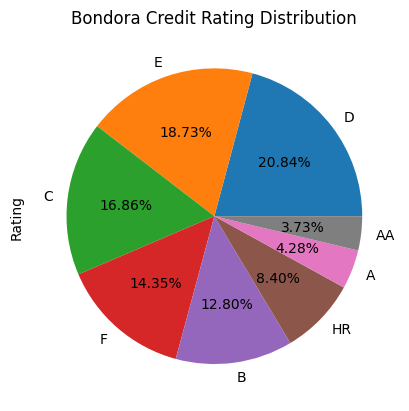

In [29]:
obj_data.Rating.value_counts().plot(kind='pie', autopct='%1.2f%%')
plt.title('Bondora Credit Rating Distribution')
plt.show()

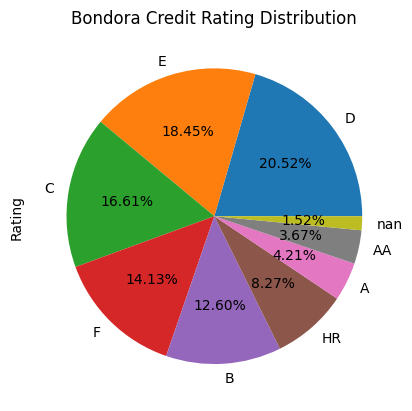

In [30]:
# obj_data.fillna('unknown', inplace=True) # there was a better way
obj_data.Rating.value_counts(dropna=False).plot(kind='pie', autopct='%1.2f%%')
plt.title('Bondora Credit Rating Distribution')
plt.show()

In [31]:
skip_cols = ['ReportAsOfEOD', 'LoanId', 'ListedOnUTC', 'BiddingStartedOn','UserName', 'LoanApplicationStartedDate', 'LoanDate', 'ContractEndDate', 'FirstPaymentDate',
             'MaturityDate_Original', 'MaturityDate_Last','LastPaymentOn', 'DebtOccuredOn', 'DebtOccuredOnForSecondary', 'DefaultDate', 'StageActiveSince', 'GracePeriodStart', 
             'GracePeriodEnd', 'NextPaymentDate','ReScheduledOn'] # turns out timestamps aren't good for pie charts
# for i, col in enumerate(obj_data.columns):
#     print(f'Drawing chart {i + 1} of {len(obj_data.columns)}: {col}')
#     if col in skip_cols:
#         print(f'Skipping column: {col}')
#         continue
#     pandas.Series(obj_data[col]).value_counts(dropna=False).plot(kind='pie', autopct='%1.2f%%')
#     plt.title(f'Bondora {col} Distribution')
#     plt.show()

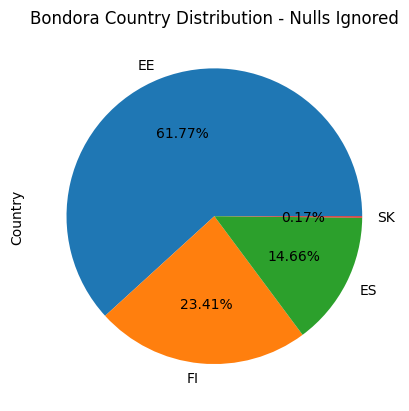

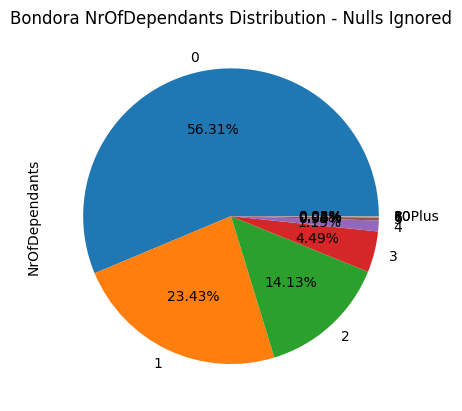

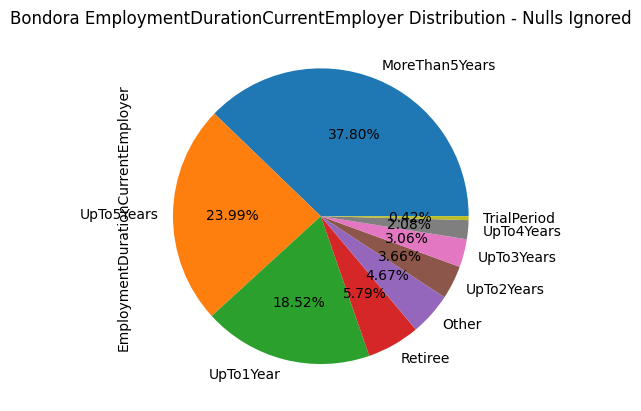

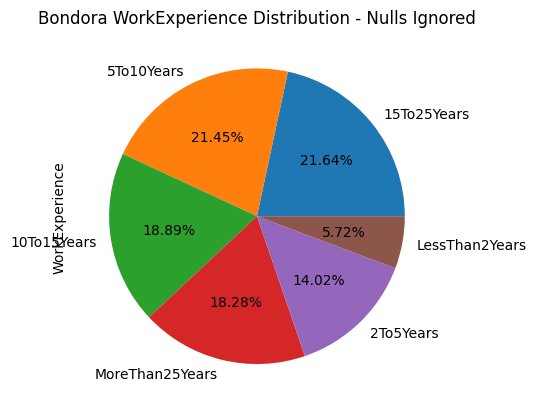

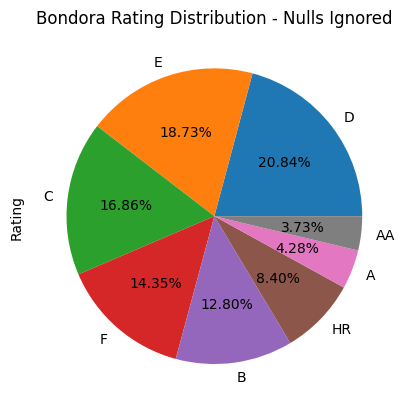

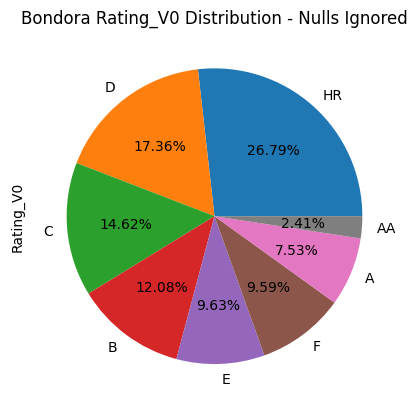

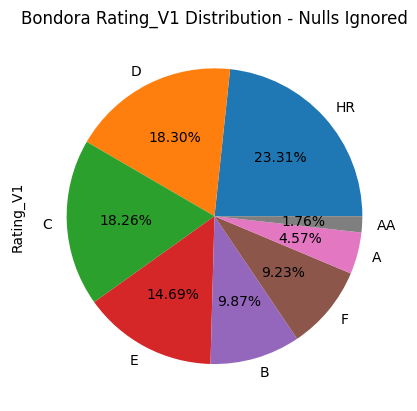

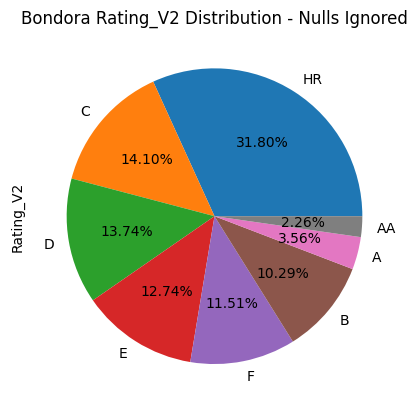

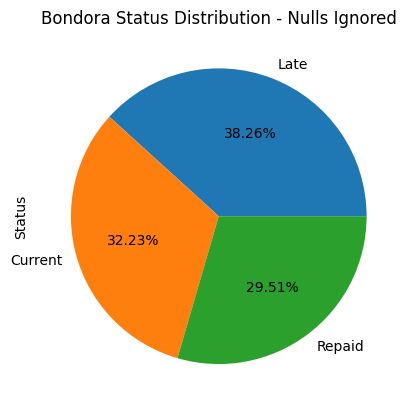

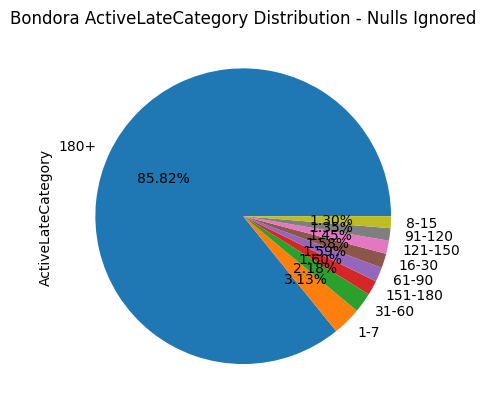

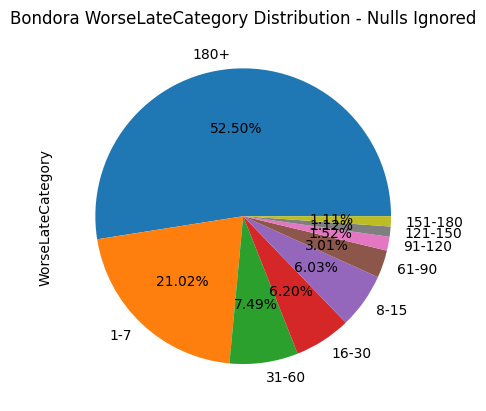

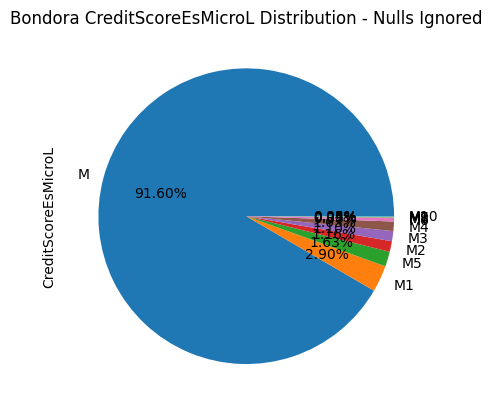

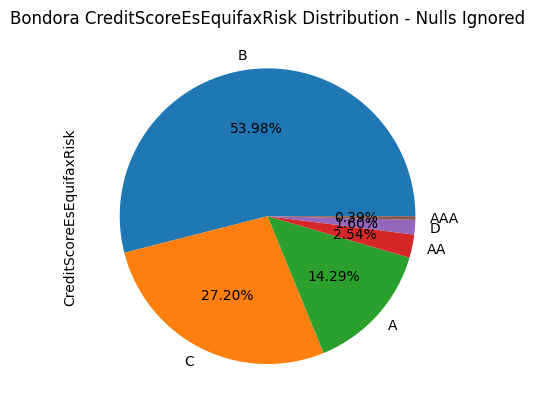

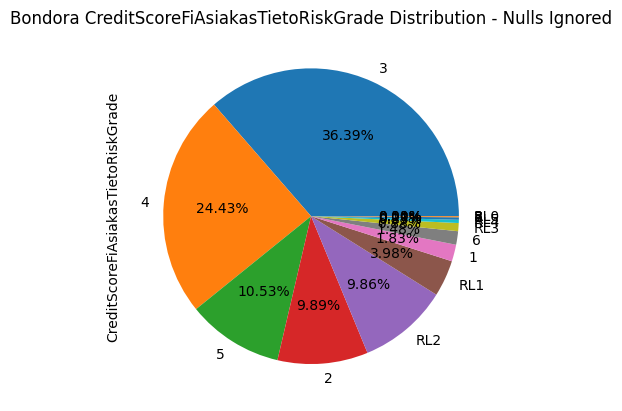

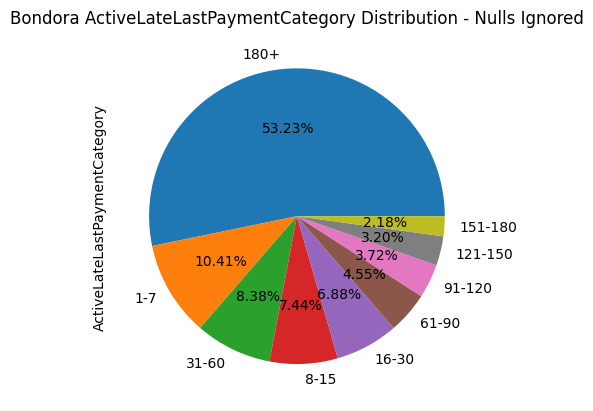

In [32]:
for col in obj_data.columns:
    if col in skip_cols: continue
    pandas.Series(obj_data[col]).value_counts().plot(kind='pie', autopct='%1.2f%%')
    plt.title(f'Bondora {col} Distribution - Nulls Ignored')
    plt.show()

Might as well drop the `skip_cols` altogether.

In [33]:
obj_data.drop(skip_cols, axis=1, inplace=True)

Now for the `bool` columns.

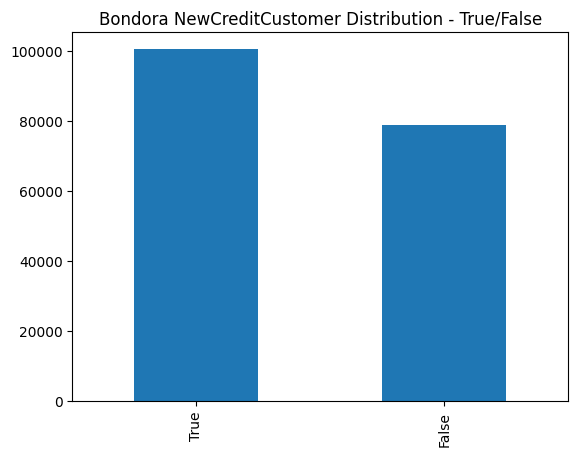

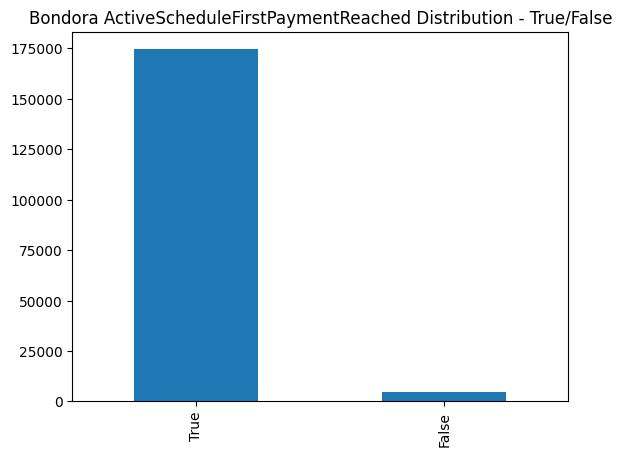

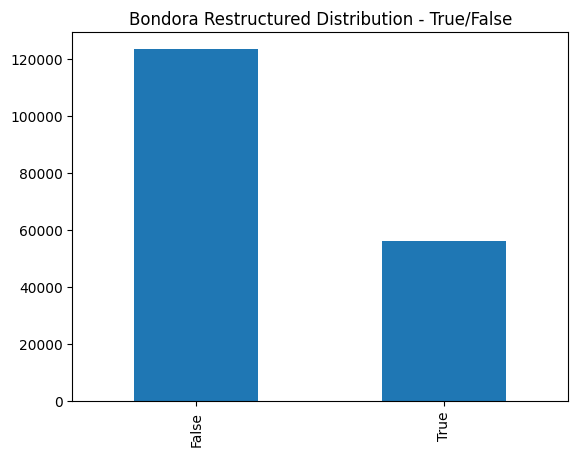

In [34]:
for col in bool_data.columns:
    pandas.Series(bool_data[col]).value_counts().plot(kind='bar')
    plt.title(f'Bondora {col} Distribution - True/False')
    plt.show()

Not much to see here. Numeric data won't be explored so much as imputed, so it's time for...

In [35]:
import numpy
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

Flatten the object (category) columns...

In [36]:
obj_array = numpy.array(obj_data).reshape(-1) # -1 flattens to a 1D array
obj_array

array(['EE', '0', 'MoreThan5Years', ..., nan, nan, '180+'], dtype=object)

...in order to map (encode) them to a unique numeric value so they can be run through ML models.

In [37]:
obj_map = LabelEncoder().fit_transform(obj_array) # maps the labels from the original array to a new one 
n_rows = len(obj_data.index)
n_cols = int(obj_map.shape[0] / n_rows) # distributes the mapping's length across the re-expanded rows
pandas.DataFrame(obj_map.reshape(n_rows, n_cols))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,32,0,51,8,28,68,68,28,37,10,10,68,68,68,14
1,32,0,51,50,27,68,27,27,37,10,10,68,68,68,10
2,32,1,65,50,24,68,68,24,59,10,10,68,68,68,10
3,33,0,67,17,34,68,34,36,37,10,10,43,27,68,10
4,33,11,63,17,36,68,68,36,37,10,10,45,28,68,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179230,35,0,67,5,31,68,31,36,37,10,10,68,68,55,10
179231,35,0,51,8,30,68,68,30,59,68,68,68,68,55,68
179232,33,0,51,8,36,68,68,36,59,68,9,44,28,68,68
179233,32,0,65,50,28,68,28,30,59,68,68,68,68,68,68


*SPOILER ALERT: Creating `obj_map` as a one-liner:*
```
    obj_map = LabelEncoder().fit_transform(obj_array)
```
*Instead of instantiating an `obj_encoder` first:*
```
    obj_encoder = LabelEncoder()
    obj_map = obj_encoder.fit_transform(obj_array)
```
*Causes a rewrite in the near future.*

Now to add in the boolean data.

In [38]:
bool_array = numpy.array(bool_data).reshape(-1)
bool_map = LabelEncoder().fit_transform(bool_array)
pandas.DataFrame(bool_map.reshape(len(bool_data.index), int(bool_map.shape[0] / len(bool_data.index))))

,0,1,2
0,0,1,0
1,0,1,0
2,1,1,0
3,1,1,0
4,1,1,0
...,...,...,...
179230,1,1,0
179231,0,1,0
179232,0,1,0
179233,1,1,0


In [39]:
obj_exp = pandas.DataFrame(obj_map.reshape(n_rows, n_cols))
bool_exp = pandas.DataFrame(bool_map.reshape(n_rows, 3))

In [40]:
obj_exp.columns = obj_data.columns # this is why skip_cols got dropped earlier
bool_exp.columns = bool_data.columns

We'll combine these into one dataframe:

In [41]:
categorical_data = pandas.concat([obj_exp, bool_exp], axis=1)
categorical_data

,Country,NrOfDependants,EmploymentDurationCurrentEmployer,WorkExperience,Rating,Rating_V0,Rating_V1,Rating_V2,Status,ActiveLateCategory,WorseLateCategory,CreditScoreEsMicroL,CreditScoreEsEquifaxRisk,CreditScoreFiAsiakasTietoRiskGrade,ActiveLateLastPaymentCategory,NewCreditCustomer,ActiveScheduleFirstPaymentReached,Restructured
0,32,0,51,8,28,68,68,28,37,10,10,68,68,68,14,0,1,0
1,32,0,51,50,27,68,27,27,37,10,10,68,68,68,10,0,1,0
2,32,1,65,50,24,68,68,24,59,10,10,68,68,68,10,1,1,0
3,33,0,67,17,34,68,34,36,37,10,10,43,27,68,10,1,1,0
4,33,11,63,17,36,68,68,36,37,10,10,45,28,68,10,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179230,35,0,67,5,31,68,31,36,37,10,10,68,68,55,10,1,1,0
179231,35,0,51,8,30,68,68,30,59,68,68,68,68,55,68,0,1,0
179232,33,0,51,8,36,68,68,36,59,68,9,44,28,68,68,0,1,0
179233,32,0,65,50,28,68,28,30,59,68,68,68,68,68,68,1,1,0


Now it's time to impute (read: fill missing values for, *TIL*) the numeric data.

#### Imputing Numeric Data

In [42]:
numeric_data

,LoanNumber,BidsPortfolioManager,BidsApi,BidsManual,ApplicationSignedHour,ApplicationSignedWeekday,VerificationType,LanguageCode,Age,DateOfBirth,...,InterestAndPenaltyBalance,NoOfPreviousLoansBeforeLoan,AmountOfPreviousLoansBeforeLoan,PreviousRepaymentsBeforeLoan,PreviousEarlyRepaymentsBefoleLoan,PreviousEarlyRepaymentsCountBeforeLoan,NextPaymentNr,NrOfScheduledPayments,PrincipalDebtServicingCost,InterestAndPenaltyDebtServicingCost
0,483449,970,1150,5.0,17,4,4.0,1,53,NaN,...,433.60,1.0,500.0,590.95,0.0,0.0,NaN,NaN,0.00,51.73
1,378148,1295,0,1705.0,11,5,1.0,1,50,NaN,...,2291.82,1.0,1800.0,445.26,3000.0,1.0,NaN,NaN,0.00,47.08
2,451831,2700,565,5835.0,22,3,4.0,1,44,NaN,...,0.00,0.0,0.0,0.00,0.0,0.0,NaN,NaN,259.67,1659.60
3,349381,1115,0,385.0,15,3,3.0,6,42,NaN,...,2833.83,0.0,0.0,0.00,1500.0,1.0,NaN,NaN,0.00,215.05
4,443082,305,0,785.0,20,3,4.0,6,34,NaN,...,4215.37,0.0,0.0,0.00,0.0,0.0,NaN,NaN,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179230,323749,2000,0,0.0,7,2,1.0,4,38,NaN,...,4284.86,0.0,0.0,0.00,0.0,0.0,NaN,NaN,0.00,18.38
179231,468598,6215,70,1155.0,11,5,4.0,4,37,NaN,...,0.00,2.0,2500.0,986.78,0.0,0.0,NaN,NaN,0.00,0.00
179232,462572,430,0,1055.0,14,4,1.0,6,37,NaN,...,0.00,3.0,2425.0,2749.65,1200.0,1.0,NaN,NaN,0.00,0.00
179233,396046,3000,0,0.0,20,2,1.0,3,58,NaN,...,0.00,0.0,0.0,0.00,0.0,0.0,NaN,NaN,0.00,0.00


In [43]:
# by default columns with all null values are dropped, but that throws off the column names so life is easier if I keep them for now
median_imputer = SimpleImputer(missing_values=numpy.nan, strategy='median', keep_empty_features=True) 
print(numeric_data.shape)
median_imputer.fit(numpy.array(numeric_data))
print(numeric_data.shape)
imputed_data = median_imputer.transform(numeric_data)
print(imputed_data.shape)
pandas.DataFrame(imputed_data, columns=numeric_data.columns)

(179235, 74)
(179235, 74)


g:\DevProjects\fintech-bootcamp-at-home\.venv\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


(179235, 74)


,LoanNumber,BidsPortfolioManager,BidsApi,BidsManual,ApplicationSignedHour,ApplicationSignedWeekday,VerificationType,LanguageCode,Age,DateOfBirth,...,InterestAndPenaltyBalance,NoOfPreviousLoansBeforeLoan,AmountOfPreviousLoansBeforeLoan,PreviousRepaymentsBeforeLoan,PreviousEarlyRepaymentsBefoleLoan,PreviousEarlyRepaymentsCountBeforeLoan,NextPaymentNr,NrOfScheduledPayments,PrincipalDebtServicingCost,InterestAndPenaltyDebtServicingCost
0,483449.0,970.0,1150.0,5.0,17.0,4.0,4.0,1.0,53.0,0.0,...,433.60,1.0,500.0,590.95,0.0,0.0,2.0,60.0,0.00,51.73
1,378148.0,1295.0,0.0,1705.0,11.0,5.0,1.0,1.0,50.0,0.0,...,2291.82,1.0,1800.0,445.26,3000.0,1.0,2.0,60.0,0.00,47.08
2,451831.0,2700.0,565.0,5835.0,22.0,3.0,4.0,1.0,44.0,0.0,...,0.00,0.0,0.0,0.00,0.0,0.0,2.0,60.0,259.67,1659.60
3,349381.0,1115.0,0.0,385.0,15.0,3.0,3.0,6.0,42.0,0.0,...,2833.83,0.0,0.0,0.00,1500.0,1.0,2.0,60.0,0.00,215.05
4,443082.0,305.0,0.0,785.0,20.0,3.0,4.0,6.0,34.0,0.0,...,4215.37,0.0,0.0,0.00,0.0,0.0,2.0,60.0,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179230,323749.0,2000.0,0.0,0.0,7.0,2.0,1.0,4.0,38.0,0.0,...,4284.86,0.0,0.0,0.00,0.0,0.0,2.0,60.0,0.00,18.38
179231,468598.0,6215.0,70.0,1155.0,11.0,5.0,4.0,4.0,37.0,0.0,...,0.00,2.0,2500.0,986.78,0.0,0.0,2.0,60.0,0.00,0.00
179232,462572.0,430.0,0.0,1055.0,14.0,4.0,1.0,6.0,37.0,0.0,...,0.00,3.0,2425.0,2749.65,1200.0,1.0,2.0,60.0,0.00,0.00
179233,396046.0,3000.0,0.0,0.0,20.0,2.0,1.0,3.0,58.0,0.0,...,0.00,0.0,0.0,0.00,0.0,0.0,2.0,60.0,0.00,0.00


In [44]:
numeric_data.describe()

,LoanNumber,BidsPortfolioManager,BidsApi,BidsManual,ApplicationSignedHour,ApplicationSignedWeekday,VerificationType,LanguageCode,Age,DateOfBirth,...,InterestAndPenaltyBalance,NoOfPreviousLoansBeforeLoan,AmountOfPreviousLoansBeforeLoan,PreviousRepaymentsBeforeLoan,PreviousEarlyRepaymentsBefoleLoan,PreviousEarlyRepaymentsCountBeforeLoan,NextPaymentNr,NrOfScheduledPayments,PrincipalDebtServicingCost,InterestAndPenaltyDebtServicingCost
count,1.792350e+05,179235.000000,179235.000000,179235.000000,179235.000000,179235.000000,179185.000000,179235.000000,179235.000000,0.0,...,174003.000000,179226.000000,179226.000000,116849.000000,58885.000000,179226.000000,112291.000000,112291.000000,76150.000000,76150.000000
mean,1.239306e+06,797.962530,27.432337,499.544776,13.325260,3.917907,3.043402,2.675153,40.389137,NaN,...,939.417878,1.575597,3129.574483,978.885518,364.810843,0.062686,5.673491,53.633773,9.291100,158.354431
std,6.610266e+05,1235.509764,147.568318,714.723996,4.995317,1.752335,1.352504,1.874840,12.359547,NaN,...,2966.287413,2.520403,4887.281797,1956.009612,1660.148567,0.340707,8.472659,12.393257,75.611465,366.688541
min,3.700000e+01,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,NaN,...,-2.660000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,7.125380e+05,105.000000,0.000000,50.000000,10.000000,2.000000,1.000000,1.000000,31.000000,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,48.000000,0.000000,0.000000
50%,1.096557e+06,336.000000,0.000000,258.000000,13.000000,4.000000,4.000000,2.000000,39.000000,NaN,...,0.000000,1.000000,530.000000,279.280000,0.000000,0.000000,2.000000,60.000000,0.000000,0.000000
75%,1.851458e+06,960.000000,4.000000,639.116700,17.000000,5.000000,4.000000,4.000000,49.000000,NaN,...,524.265000,2.000000,4253.000000,940.520000,0.000000,0.000000,8.000000,60.000000,0.000000,140.520000
max,2.313298e+06,10625.000000,7570.000000,10630.000000,23.000000,7.000000,4.000000,22.000000,77.000000,NaN,...,78982.070000,27.000000,72778.000000,34077.420000,48100.000000,11.000000,60.000000,72.000000,3325.330000,5824.550000


I don't really understand how this works, but the way [Google](https://developers.google.com/machine-learning/data-prep/transform/normalization) explains it, the difference between every point and the mean is measured, and then that difference is divided by 1 standard deviation at each of those points to scale all data to their number of standard deviations from the mean.

In [45]:
normalized_data = (numeric_data - numeric_data.mean(axis=0)) / numeric_data.std(axis=0) 
normalized_data 

,LoanNumber,BidsPortfolioManager,BidsApi,BidsManual,ApplicationSignedHour,ApplicationSignedWeekday,VerificationType,LanguageCode,Age,DateOfBirth,...,InterestAndPenaltyBalance,NoOfPreviousLoansBeforeLoan,AmountOfPreviousLoansBeforeLoan,PreviousRepaymentsBeforeLoan,PreviousEarlyRepaymentsBefoleLoan,PreviousEarlyRepaymentsCountBeforeLoan,NextPaymentNr,NrOfScheduledPayments,PrincipalDebtServicingCost,InterestAndPenaltyDebtServicingCost
0,-1.143460,0.139244,7.607105,-0.691938,0.735637,0.046848,0.707279,-0.893491,1.020334,NaN,...,-0.170522,-0.228375,-0.538044,-0.198330,-0.219746,-0.183988,NaN,NaN,-0.122880,-0.290777
1,-1.302759,0.402293,-0.185896,1.686602,-0.465488,0.617515,-1.510829,-0.893491,0.777606,NaN,...,0.455924,-0.228375,-0.272048,-0.272813,1.587321,2.751081,NaN,NaN,-0.122880,-0.303458
2,-1.191292,1.539476,3.642839,7.465057,1.736575,-0.523819,0.707279,-0.893491,0.292152,NaN,...,-0.316698,-0.625137,-0.640351,-0.500450,-0.219746,-0.183988,NaN,NaN,3.311388,4.094062
3,-1.346278,0.256605,-0.185896,-0.160264,0.335262,-0.523819,-0.032090,1.773403,0.130333,NaN,...,0.638648,-0.625137,-0.640351,-0.500450,0.683788,2.751081,NaN,NaN,-0.122880,0.154615
4,-1.204527,-0.398995,-0.185896,0.399392,1.336200,-0.523819,0.707279,1.773403,-0.516939,NaN,...,1.104395,-0.625137,-0.640351,-0.500450,-0.219746,-0.183988,NaN,NaN,-0.122880,-0.431850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179230,-1.385054,0.972908,-0.185896,-0.698934,-1.266238,-1.094486,-1.510829,0.706645,-0.193303,NaN,...,1.127821,-0.625137,-0.640351,-0.500450,-0.219746,-0.183988,NaN,NaN,-0.122880,-0.381726
179231,-1.165927,4.384455,0.288461,0.917075,-0.465488,0.617515,0.707279,0.706645,-0.274212,NaN,...,-0.316698,0.168387,-0.128819,0.004036,-0.219746,-0.183988,NaN,NaN,-0.122880,-0.431850
179232,-1.175043,-0.297822,-0.185896,0.777160,0.135074,0.046848,-1.510829,1.773403,-0.274212,NaN,...,-0.316698,0.565149,-0.144165,0.905294,0.503081,2.751081,NaN,NaN,-0.122880,-0.431850
179233,-1.275683,1.782291,-0.185896,-0.698934,1.336200,-1.094486,-1.510829,0.173267,1.424879,NaN,...,-0.316698,-0.625137,-0.640351,-0.500450,-0.219746,-0.183988,NaN,NaN,-0.122880,-0.431850


#### Refactoring

In [46]:
obj_data['Status']

0           Late
1           Late
2         Repaid
3           Late
4           Late
           ...  
179230      Late
179231    Repaid
179232    Repaid
179233    Repaid
179234    Repaid
Name: Status, Length: 179235, dtype: object

In [47]:
# target = obj_data['Status']
# categorical_data.drop(['Status'], axis=1, inplace=True)
# target = obj_encoder.inverse_transform(target) # <-- obj_encoder did not originally exist, and it should have
# target = pandas.DataFrame(target, columns=['Status'])
# target.Status.unique()

^ It was at this moment I knew I messed up... `obj_encoder` should've been setup before preprocessing. I tried to rework earlier cells, but it started turning into a rewrite of the notebook; since I already planned to consolidate that code for the other 3 datasets, we'll do that now and leave what's been done so far for reference.

In [48]:
# def fix_date_dtype(data:pandas.DataFrame) -> pandas.DataFrame:
#     result = data.copy()
#     for col in data.select_dtypes('object'):
#         try: # yes this is the best way
#             result[col] = pandas.to_datetime(data[col])
#         except (pandas.errors.ParserError, ValueError):
#             pass # non-datetime field to skip over
#     return result

# def drop_null(data:pandas.DataFrame, tolerance:float=0.8) -> pandas.DataFrame:
#     tolerance = max(0, min(tolerance, 1)) # clamp to [0, 1]
#     threshold = int(tolerance * len(data.index))
#     drop_cols = []
#     for col in data.columns:
#         if pandas.Series(data[col]).isnull().sum() > threshold:
#             drop_cols.append(col)
#     return data.drop(drop_cols, axis=1)

# def drop_unique(data:pandas.DataFrame) -> pandas.DataFrame:
#     drop_cols = []
#     for col in data:
#         if len(data[col].value_counts()) == len(data.index):
#             drop_cols.append(col)
#     return data.drop(drop_cols, axis=1)

def preprocess(raw_data:pandas.DataFrame, obj_encoder:LabelEncoder, target_col:str, null_tolerance:float=0.8, drop_cols:set=set(), drop_unique:bool=True) -> tuple[pandas.DataFrame, pandas.DataFrame]:
    if target_col not in raw_data.columns: raise ValueError('Target column must be in data.columns.')

    # check for null values (outside tolerance), unique values, pre-designated drop columns, and misformatted datetime columns
    null_tolerance = max(0, min(null_tolerance, 1)) # clamp to [0, 1]
    threshold = int(null_tolerance * len(raw_data))
    data = raw_data.copy()
    cat_cols = set() # I'm losing my mind right meow

    for col in data:
        # null, unique, and preset first since they're easy to check
        if pandas.Series(data[col]).isnull().sum() > threshold or (drop_unique and len(data[col].value_counts()) == len(data)) or col in drop_cols:
            drop_cols.add(col)
            continue
        
        # convert datetimes imported as objects back into datetimes (only to drop them later)
        if data.dtypes[col] == 'object': 
            try: data[col] = pandas.to_datetime(data[col])
            except (pandas.errors.ParserError, ValueError): pass
        
        # setup for categorical/numeric values
        match data.dtypes[col]:
            case 'O' | 'object' | 'bool': cat_cols.add(col)
            case 'int64' | 'float64': pass
            case _:
                print(f'WARN: Unexpected dtype for column {col}: {data.dtypes[col]}. Dropping...')
                drop_cols.add(col)
    
    data.drop(drop_cols, axis=1, inplace=True)
    
    # convert categorical variables
    X_split = []
    for cat_dtype in ['object', 'bool']:
        cat_data = data.select_dtypes(cat_dtype)
        cat_array = numpy.array(cat_data).reshape(-1)
        enc = obj_encoder if cat_dtype == 'object' else LabelEncoder() # band-aid
        cat_labels = enc.fit_transform(cat_array)
        rows = len(cat_data)
        cols = int(cat_labels.shape[0] / rows)
        X_split.append(pandas.DataFrame(cat_labels.reshape(rows, cols), columns=cat_data.columns))
    X_cat = pandas.concat(X_split, axis=1)
    
    # impute and normalize numeric variables
    num_data = data.drop(X_cat.columns, axis=1)
    med_imputer = SimpleImputer(missing_values=numpy.nan, strategy='median')
    med_imputer.fit(num_data)
    num_imputed = pandas.DataFrame(med_imputer.transform(num_data), columns=num_data.columns)
    X_num = (num_imputed - num_imputed.mean(axis=0)) / num_imputed.std(axis=0)
    
    # target selection
    Y_data = X_cat[target_col]
    Y_enc = obj_encoder.inverse_transform(Y_data)
    Y = pandas.DataFrame(Y_enc, columns=[target_col])

    # in the end it had to be this way
    X_cat.drop([target_col], axis=1, inplace=True)
    X = pandas.concat([X_cat, X_num], axis=1)
    X.dropna(inplace=True, axis=1)

    return X, Y
    

In [49]:
drop_cols = {'ReportAsOfEOD', 'LoanId', 'ListedOnUTC', 'BiddingStartedOn','UserName', 'LoanApplicationStartedDate', 'LoanDate', 'ContractEndDate', 'FirstPaymentDate',
             'MaturityDate_Original', 'MaturityDate_Last','LastPaymentOn', 'DebtOccuredOn', 'DebtOccuredOnForSecondary', 'DefaultDate', 'StageActiveSince', 'GracePeriodStart', 
             'GracePeriodEnd', 'NextPaymentDate','ReScheduledOn', 'PrincipalDebtServicingCost', 'PrincipalRecovery', 'PrincipalWriteOffs'}
obj_encoder = LabelEncoder()
X, Y_data = preprocess(data, obj_encoder, 'Status', 0.5, drop_cols)

In [50]:
X

,Country,EmploymentDurationCurrentEmployer,Rating,WorseLateCategory,CreditScoreEsMicroL,NewCreditCustomer,ActiveScheduleFirstPaymentReached,Restructured,BidsPortfolioManager,BidsApi,...,PrincipalPaymentsMade,InterestAndPenaltyPaymentsMade,PrincipalBalance,InterestAndPenaltyBalance,NoOfPreviousLoansBeforeLoan,AmountOfPreviousLoansBeforeLoan,PreviousRepaymentsBeforeLoan,PreviousEarlyRepaymentsCountBeforeLoan,NextPaymentNr,NrOfScheduledPayments
0,16,33,12,4,44,0,1,0,0.139244,7.607105,...,-0.002330,0.615223,-0.200374,-0.163445,-0.228369,-0.538027,-0.089477,-0.183984,-0.331731,0.387925
1,16,33,11,4,44,0,1,0,0.402293,-0.185896,...,-0.277416,-0.249749,0.460404,0.471421,-0.228369,-0.272026,-0.179738,2.751157,-0.331731,0.387925
2,16,41,9,4,44,1,1,0,1.539476,3.642839,...,3.774172,1.159132,-0.796790,-0.311586,-0.625141,-0.640336,-0.455593,-0.183984,-0.331731,0.387925
3,17,43,18,4,26,1,1,0,0.256605,-0.185896,...,-0.344470,-0.254085,-0.262588,0.656600,-0.625141,-0.640336,-0.455593,2.751157,-0.331731,0.387925
4,17,39,20,4,28,1,1,0,-0.398995,-0.185896,...,-0.659675,-0.625969,-0.234352,1.128607,-0.625141,-0.640336,-0.455593,-0.183984,-0.331731,0.387925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179230,19,43,15,4,44,1,1,0,0.972908,-0.185896,...,-0.659682,-0.625969,0.235215,1.152349,-0.625141,-0.640336,-0.455593,-0.183984,-0.331731,0.387925
179231,19,33,14,44,44,0,1,0,4.384455,0.288461,...,4.386650,2.158222,-0.796790,-0.311586,0.168402,-0.128795,0.155755,-0.183984,-0.331731,0.387925
179232,17,33,20,3,27,0,1,0,-0.297822,-0.185896,...,0.347549,-0.431198,-0.796790,-0.311586,0.565174,-0.144141,1.247922,2.751157,-0.331731,0.387925
179233,16,41,12,44,44,1,1,0,1.782291,-0.185896,...,1.375129,1.437304,-0.796790,-0.311586,-0.625141,-0.640336,-0.455593,-0.183984,-0.331731,0.387925


In [51]:
Y_data

,Status
0,Late
1,Late
2,Repaid
3,Late
4,Late
...,...
179230,Late
179231,Repaid
179232,Repaid
179233,Repaid


This still needs a bit of cleaning up

In [52]:
Y_data.Status.unique()

array(['Late', 'Repaid', 'Current'], dtype=object)

~~The goal is to determine the likelihood of loans being `'Late'` vs `'Repaid'`, so `'Current'` gets dropped. There's an argument to be made for keeping `'Current'` and encoding it the same as `'Repaid'`, but now is not the time.~~

Screw it, including it actually solves more problems than excluding it does. I'll justify it post hoc since `'Current'` is arguably a good state for the loan as well.

In [53]:
# Y = Y.loc[Y.Status!='Current']
# Y

In [54]:
Y_data.replace(['Late', 'Repaid', 'Current'], [0, 1, 1], inplace=True)
Y_data

,Status
0,0
1,0
2,1
3,0
4,0
...,...
179230,0
179231,1
179232,1
179233,1


This part may get moved into `preprocess()` later. Depends on how clean the other datasets are.

In [55]:
processed_data = pandas.concat([X, Y_data], axis=1)
processed_data

,Country,EmploymentDurationCurrentEmployer,Rating,WorseLateCategory,CreditScoreEsMicroL,NewCreditCustomer,ActiveScheduleFirstPaymentReached,Restructured,BidsPortfolioManager,BidsApi,...,InterestAndPenaltyPaymentsMade,PrincipalBalance,InterestAndPenaltyBalance,NoOfPreviousLoansBeforeLoan,AmountOfPreviousLoansBeforeLoan,PreviousRepaymentsBeforeLoan,PreviousEarlyRepaymentsCountBeforeLoan,NextPaymentNr,NrOfScheduledPayments,Status
0,16,33,12,4,44,0,1,0,0.139244,7.607105,...,0.615223,-0.200374,-0.163445,-0.228369,-0.538027,-0.089477,-0.183984,-0.331731,0.387925,0
1,16,33,11,4,44,0,1,0,0.402293,-0.185896,...,-0.249749,0.460404,0.471421,-0.228369,-0.272026,-0.179738,2.751157,-0.331731,0.387925,0
2,16,41,9,4,44,1,1,0,1.539476,3.642839,...,1.159132,-0.796790,-0.311586,-0.625141,-0.640336,-0.455593,-0.183984,-0.331731,0.387925,1
3,17,43,18,4,26,1,1,0,0.256605,-0.185896,...,-0.254085,-0.262588,0.656600,-0.625141,-0.640336,-0.455593,2.751157,-0.331731,0.387925,0
4,17,39,20,4,28,1,1,0,-0.398995,-0.185896,...,-0.625969,-0.234352,1.128607,-0.625141,-0.640336,-0.455593,-0.183984,-0.331731,0.387925,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179230,19,43,15,4,44,1,1,0,0.972908,-0.185896,...,-0.625969,0.235215,1.152349,-0.625141,-0.640336,-0.455593,-0.183984,-0.331731,0.387925,0
179231,19,33,14,44,44,0,1,0,4.384455,0.288461,...,2.158222,-0.796790,-0.311586,0.168402,-0.128795,0.155755,-0.183984,-0.331731,0.387925,1
179232,17,33,20,3,27,0,1,0,-0.297822,-0.185896,...,-0.431198,-0.796790,-0.311586,0.565174,-0.144141,1.247922,2.751157,-0.331731,0.387925,1
179233,16,41,12,44,44,1,1,0,1.782291,-0.185896,...,1.437304,-0.796790,-0.311586,-0.625141,-0.640336,-0.455593,-0.183984,-0.331731,0.387925,1


*And now for the moment you've been waiting for...*

#### Preparing the Krabby Patty 🍔

In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [57]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_data, test_size=0.2, random_state=24)

In [58]:
len(X_train) / len(X)

0.8

In [59]:
dec_tree = DecisionTreeClassifier(random_state=4)
classifier_params = { 'criterion' : ['gini', 'entropy'],
           'max_depth'  : [20, 21], 
           'min_samples_split' : [50, 51],   }
grid_search = GridSearchCV(dec_tree, classifier_params, n_jobs=50, verbose=100, cv=2, refit='best_params_')
grid_search.fit(X_train, Y_train)

Fitting 2 folds for each of 8 candidates, totalling 16 fits


GridSearchCV(cv=2, estimator=DecisionTreeClassifier(random_state=4), n_jobs=50,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [20, 21], 'min_samples_split': [50, 51]},
             refit='best_params_', verbose=100)

🐕 I have no idea what I'm doing

In [60]:
print('Best parameters for DT Classifier', grid_search.best_params_)

Best parameters for DT Classifier {'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 51}


In [61]:
predictions = grid_search.predict(X_test)
failure_rate, success_rate, thresholds = metrics.roc_curve(Y_test, predictions) # technically false positive and true positive rate, but I don't like their acronyms
auc_score = metrics.auc(failure_rate, success_rate)
print(f'AUC Score: {auc_score}')

AUC Score: 0.9939086032747508


Once again, [Google](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc) knows da wae.

ROC Curve = A plot of TPR (True Positive Rate) vs FPR (False Positive Rate) for a classifier at different classification thresholds; a lower threshold = more positives overall (and thus higher false *and* true positives.)

AUC Score = Measures the area under the ROC Curve to solve a problem I'm not familiar with in a way I don't understand. The key is it's clamped to [0, 1], 0.0 = 100% wrong, and 1.0 = 100% correct.

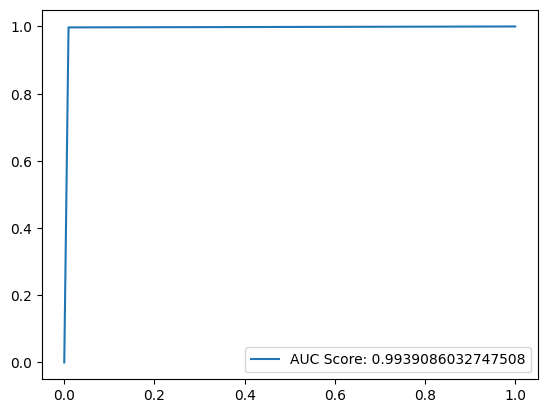

In [62]:
plt.plot(failure_rate, success_rate, label=f'AUC Score: {auc_score}')
plt.legend(loc=4)
plt.show()

#### Feature Importance

And this is where the [guide notebook](https://www.kaggle.com/code/leventoz/default-loans-predictor-acc-99-99#-Roc-Score-on-the-Validation-set-=-99.99%-) ends, but someone made [this point](https://www.kaggle.com/code/leventoz/default-loans-predictor-acc-99-99/comments#2105450) in the comments:

>*During training and prediction, you have including*[sic] *highly status correlated data like "ActiveLateCategory", "DefaultDate", "PrincipalOverdueBySchedule", "Recoverystage", etc. As a result, your model seems to learn the correlation of status and data directly produced by such status but not known during or at the start of a loan.*

Thankfully, they also detailed how to check for feature importance:

In [63]:
importance = pandas.DataFrame(numpy.array(grid_search.best_estimator_.feature_importances_))
importance.index = X_train.columns
importance.sort_values(0)

,0
IncomeFromFamilyAllowance,0.000000
EmploymentStatus,0.000000
MaritalStatus,0.000000
UseOfLoan,0.000000
FreeCash,0.000000
...,...
MonthlyPaymentDay,0.016409
PrincipalBalance,0.049635
NextPaymentNr,0.054801
PrincipalOverdueBySchedule,0.144737


They also recommended using only data available when a loan is on auction, since that's when the prediction is needed. Using the [Bondora API docs](https://api.bondora.com/doc/ResourceModel?modelName=Auction&v=1) the columns for this data are:

In [64]:
available_at_auction = { 'LoanId', 'AuctionId', 'LoanNumber', 'UserName', 'NewCreditCustomer', 'LoanApplicationStartedDate', 'PlannedCloseDate', 'ApplicationSignedHour',
                         'ApplicationSignedWeekday', 'VerificationType', 'LanguageCode', 'Age', 'DateOfBirth', 'Gender', 'Country', 'CreditScoreEsMicroL', 
                         'CreditScoreEsEquifaxRisk', 'CreditScoreFiAsiakasTietoRiskGrade', 'CreditScoreEeMini', 'AppliedAmount', 'Interest', 'LoanDuration', 'Country',
                         'City', 'Education', 'EmploymentDurationCurrentEmployer', 'HomeOwnershipType', 'IncomeTotal', 'MonthlyPaymentDay', 'LiabilitiesTotal', 'ListedOnUTC'}


These values were skipped because they include predictions from Bondora's own model, system info that doesn't describe the loan application/applicant, or fields that would otherwise defeat the purpose of this step:
```
    'ModelVersion', 'ExpectedLoss', 'Rating', 'ProbabilityOfDefault', 'ExpectedReturnAlpha', 'ActualCloseDate', 'WinningBidsAmount', 'RemainingAmount', 'UserBids', 'UserBidAmount', 'Fullfilled'
```
(A few assumptions were made.)

#### 2nd Refactor

In [65]:
def preprocess_classifier(data_path:str, Y_column:str, Y_value_map:dict, **kwargs) -> tuple[pandas.DataFrame, pandas.DataFrame]:
    
    # load data, capture Y (target) data before it gets dropped
    data = pandas.read_csv(data_path, engine='python')
    Y_data = data[Y_column].replace([k for k in Y_value_map], [Y_value_map[k] for k in Y_value_map])

    # apply config
    null_threshold = 0.8 * len(data)
    unique_threshold = len(data)
    for kw in kwargs:
        match kw:
            case 'null_tolerance': null_threshold = kwargs[kw] * len(data)
            case 'null_threshold': null_threshold = kwargs[kw]
            case 'unique_tolerance': unique_threshold = kwargs[kw] * len(data)
            case 'unique_threshold': unique_threshold = kwargs[kw]
            case 'drop_columns': data.drop(kwargs[kw], axis=1, inplace=True)
            case 'keep_columns': 
                drop = set(data.columns) - set(kwargs[kw])
                data.drop(list(drop), axis=1, inplace=True)
    
    # filter data based on config
    object_columns = set()
    bool_columns = set()
    numeric_columns = set()
    for column in data:
        if data[column].isnull().sum() >= null_threshold or data[column].nunique() >= unique_threshold or column == Y_column: continue
        match data.dtypes[column]:
            case 'O' | 'object': # date columns, which we want to filter, may be brought in as object
                try: pandas.to_datetime(data[column]) # we can test for them by attempting to convert
                except (pandas.errors.ParserError, ValueError): object_columns.add(column)
            case 'bool': bool_columns.add(column)
            case 'int64' | 'float64': numeric_columns.add(column)
    
    # split data by dtype
    object_data = data[list(object_columns)]
    bool_data = data[list(bool_columns)]
    numeric_data = data[list(numeric_columns)]
    X_data = []

    # categorical (object, bool)
    for categorical_data in [object_data, bool_data]:
        labels = LabelEncoder().fit_transform(categorical_data.values.reshape(-1))
        n_rows = len(categorical_data)
        n_columns = int(labels.shape[0] / n_rows)
        X_data.append(pandas.DataFrame(labels.reshape(n_rows, n_columns), columns=categorical_data.columns))

    # numeric (int, float)
    median_imputer = SimpleImputer(missing_values=numpy.nan, strategy='median')
    median_imputer.fit(numeric_data)
    imputed_data = pandas.DataFrame(median_imputer.transform(numeric_data), columns=numeric_data.columns)
    normalized_data = (imputed_data - imputed_data.mean(axis=0)) / imputed_data.std(axis=0)
    X_data.append(normalized_data)

    # zip it up, and zip it out
    return pandas.concat(X_data, axis=1), Y_data

In [66]:
Y_map = { 'Late' : 0, 'Repaid' : 1, 'Current' : 1 }
test_X, test_Y = preprocess_classifier('./data/LoanData_Bondora.csv', 'Status', Y_map, drop_columns=drop_cols)
test_Y

0         0
1         0
2         1
3         0
4         0
         ..
179230    0
179231    1
179232    1
179233    1
179234    1
Name: Status, Length: 179235, dtype: int64

In [67]:
any(test_X.isnull().sum() > 0)

False

In [68]:
classifier_params = { 'criterion' : ['gini', 'entropy'], 'max_depth'  : [20, 21], 'min_samples_split' : [50, 51] }

def run_classifier(X_data:pandas.DataFrame, Y_data:pandas.DataFrame) -> pandas.DataFrame:
    X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2)
    dec_tree = DecisionTreeClassifier(random_state=4)
    grid_search = GridSearchCV(dec_tree, classifier_params, n_jobs=50, verbose=100, cv=2, refit='best_params_')
    grid_search.fit(X_train, Y_train)
    predictions = grid_search.predict(X_test)
    failure_rate, success_rate, thresholds = metrics.roc_curve(Y_test, predictions) # technically false positive and true positive rate, but I don't like their acronyms
    auc_score = metrics.auc(failure_rate, success_rate)
    plt.plot(failure_rate, success_rate, label=f'AUC Score: {auc_score}')
    plt.legend(loc=4)
    plt.show()
    importance = pandas.DataFrame(numpy.array(grid_search.best_estimator_.feature_importances_), index=X_train.columns)
    return importance

Fitting 2 folds for each of 8 candidates, totalling 16 fits


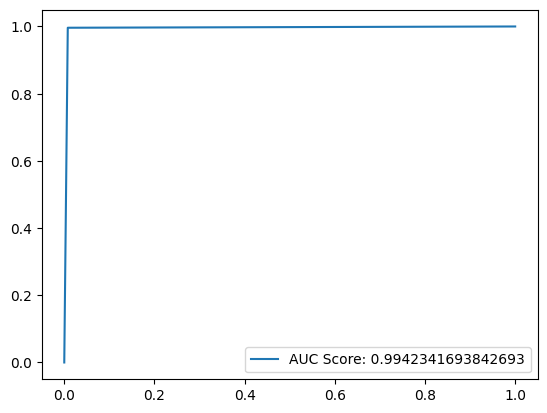

In [69]:
test_importantce = run_classifier(test_X, test_Y)

In [70]:
test_importantce.sort_values(0)

,0
IncomeFromFamilyAllowance,0.000000
MaritalStatus,0.000000
OccupationArea,0.000000
IncomeFromChildSupport,0.000000
ApplicationSignedWeekday,0.000000
...,...
MonthlyPaymentDay,0.002705
PrincipalBalance,0.048371
NextPaymentNr,0.053445
PrincipalOverdueBySchedule,0.072758


Okay it's been recreated. Now to run again, but only using data available at auction.

#### Dataset 1 Results

In [71]:
X_auction, Y_auction = preprocess_classifier('./data/LoanData_Bondora.csv', 'Status', Y_map, keep_columns=available_at_auction)

Fitting 2 folds for each of 8 candidates, totalling 16 fits


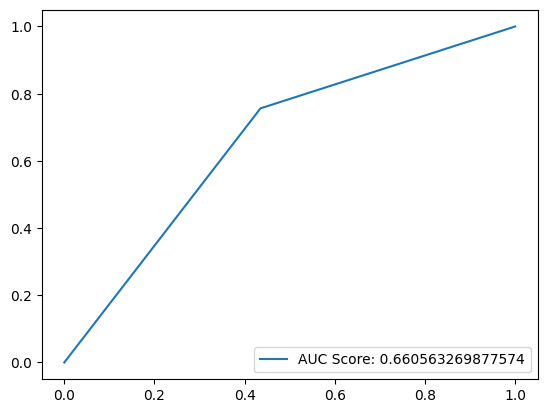

,0
CreditScoreEsMicroL,0.006434
LanguageCode,0.007764
NewCreditCustomer,0.008499
CreditScoreFiAsiakasTietoRiskGrade,0.011901
Gender,0.012628
ApplicationSignedWeekday,0.013851
CreditScoreEeMini,0.014500
EmploymentDurationCurrentEmployer,0.016597
VerificationType,0.018118
Education,0.021873


In [72]:
auction_run = run_classifier(X_auction, Y_auction)
auction_run.sort_values(0)

Not as performant, but more in line with expectations. I pulled an [updated copy](https://www.bondora.com/en/public-reports) of the loan data so let's see what that looks like:

Fitting 2 folds for each of 8 candidates, totalling 16 fits


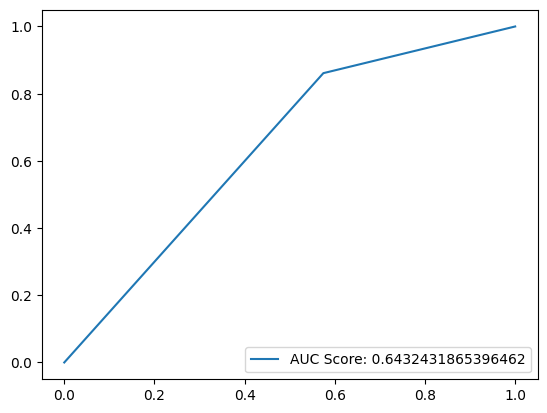

,0
NewCreditCustomer,0.005086
Gender,0.010040
CreditScoreFiAsiakasTietoRiskGrade,0.010838
CreditScoreEeMini,0.013047
EmploymentDurationCurrentEmployer,0.014086
VerificationType,0.014240
ApplicationSignedWeekday,0.016736
LanguageCode,0.019263
Education,0.021250
HomeOwnershipType,0.025137


In [73]:
X_updated, Y_updated = preprocess_classifier('./data/LoanData_Bondora_updated.csv', 'Status', Y_map, keep_columns=available_at_auction)
updated_run = run_classifier(X_updated, Y_updated)
updated_run.sort_values(0)